In [53]:
from gensim.models import Word2Vec
from w2v_random_forest import W2V_RandomForest
from w2v_kmeans import W2V_KMeans

from datetime import datetime
import re
import time
import numpy as np
import random
import argparse
import duckdb

from pathlib import Path

%matplotlib inline

In [6]:
db_string   = "/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/database/w2v_20240731_test.db"
output_dir  ='/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/logs/clustering/'

## UTILS

In [47]:
#
# W2V_PFAM_CLAN_MC1 has 15,481 entries
#
def execute_db_query():
    con = duckdb.connect(database=db_string)
    try:
        
        #results = con.execute("DESCRIBE W2V_PFAM_CLAN_MC1").fetchall()
        #results = con.execute("DESCRIBE W2V_CLAN_PFAM_COUNT").fetchall()
        #results = con.execute("SELECT DISTINCT CLAN_ID FROM W2V_PFAM_CLAN_MC1").fetchall()
        
        # really useful to find which clans have more than one pfam
        #results = con.execute("SELECT CLAN_ID, COUNT(*) AS item_count FROM W2V_PFAM_CLAN_MC1 GROUP BY CLAN_ID ORDER BY item_count DESC").fetchall()
        
        #results = con.execute("SELECT COUNT(*) FROM W2V_CLAN_PFAM_COUNT").fetchall()     
        #results = con.execute("SELECT COUNT(*) FROM W2V_PFAM_CLAN_MC1").fetchall()
        #results = con.execute("SELECT COUNT(*) FROM W2V_PFAM_CLAN_MC1 WHERE CLAN_ID='undef'").fetchall()
        result = con.execute(f"SELECT PFAM_ID, CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID ='{pfam_id}'").fetchall()
        
        #results = con.execute("SELECT CLAN_ID, COUNT(*) AS item_count FROM W2V_PFAM_CLAN_MC1 GROUP BY CLAN_ID").fetchall()

        for res in results:
            print(res)
    except Exception as e:
        print('Error executing query :', e)
        con.close()
        return
    con.close()
execute_db_query()

(7966,)


In [70]:
def find_files(directory, extn):
    files_info = []
    # Traverse the directory recursively
    for file_path in Path(directory).rglob(f"*{extn}"):
        if file_path.is_file():  # Check if it's a file
            filename = file_path.stem  # Get the filename without extension
            file_extension = file_path.suffix  # Get the file extension
            files_info.append((str(file_path), filename, file_extension))
    return files_info

In [109]:
def graph_2d_pca(X, model_name):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.datasets import make_blobs

    # Generate a random multi-dimensional dataset (e.g., 5 dimensions)
    #X, _ = make_blobs(n_samples=100, n_features=5, centers=3, random_state=42)

    # Apply PCA to reduce it to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    comic_font = {'fontname':'Comic Sans MS'}
    helv_font = {'fontname':'Helvetica'}

    # Plot the 2D projection
    plt.figure(figsize=(4, 3))
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c='#069AF3', marker='o', edgecolor='#069AF3', s=10)
    plt.title(f"W2V Model : {model_name} - Principal Components", **helv_font)
    
    # change size of font used for tick marks on axes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # label the axes - using a font
    plt.xlabel("Vocab : PC 1", **helv_font)
    plt.ylabel("Vocab : PC 2", **helv_font)
    
    plt.grid(False)
    plt.show()

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

# Sample data in a 2D array X (n_points, 2)
# For example, 100 points in 2D space (X-coordinates in column 0, Y-coordinates in column 1)
#X = np.random.rand(100, 2)

# Categories (e.g., a variable number of categories)
#categories = np.random.randint(0, 15, size=100)

def graph_2d_pca_color(X_full, categories, title):
    comic_font = {'fontname':'Comic Sans MS'}
    helv_font = {'fontname':'Helvetica'}
    
    categores_np = np.array(categories)
    # Get the unique categories
    unique_categories = np.unique(categores_np)
    
    # reduce X into 2 dimensions
    pca = PCA(n_components=2)
    X = pca.fit_transform(X_full)

    # Define a colormap that can handle the variable number of categories
    cmap = plt.get_cmap('tab20', len(unique_categories))

    # Plotting
    plt.figure(figsize=(8, 6))

    # Scatter plot where the color depends on the category
    for i, category in enumerate(unique_categories):
        # Filter points that belong to this category
        #X_cat = X[categories == category]  # Select the rows where the category matches
        
        indices = np.where(categores_np == category)
        X_cat = X[indices]
        #print(f"Category {category}. {X_cat.sum()} items in X with that cat")
        
        # Plot points with a color corresponding to the category
        #plt.scatter(X_cat[:, 0], X_cat[:, 1], label=f'Category {category}', color=cmap(i), s=100)
        plt.scatter(X_cat[:, 0], X_cat[:, 1], color=cmap(i), s=10)

    # Add title and labels
    plt.title("Scatter Plot of Points by Variable Categories")
    plt.xlabel("W2V Vocab Embedding - Principal Component 1")
    plt.ylabel("W2V Vocab Embedding - Principal Component 2")
    plt.title(title, **helv_font)

    # Add legend to identify categories
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    #plt.tight_layout()
    plt.show()



### PFAM Vocab utils

In [113]:
#
# extracts the words used in a word2vec model by wuerying the model itself
# returns a list of words with any whitespace remoived as well as count of the umber of items
#       
def get_pfam_vocab(model_path, exclude_gaps=False):
    model = Word2Vec.load(model_path)
    
    vocab         = model.wv.key_to_index
    pfam_vocab    = []
    for i, word in enumerate(vocab):
        if ( exclude_gaps and (word == 'GAP' or word == 'START_GAP' or word == 'STOP_GAP' or word == 'DISORDER')):
            #print('ignoring', word)
            continue
        else:
            word = word.lstrip()
            word = word.rstrip()
            pfam_vocab.append(word)
    return pfam_vocab, len(pfam_vocab)


#
# Retrieves the pfams for a model as long as they belong to a clan
#
def get_pfam_vocab_clan_only(model_path):
    model = Word2Vec.load(model_path)    
    pfam_w_clan_ids  = []
    
    full_vocab, num_items = get_pfam_vocab(model_path)
    con = duckdb.connect(database=db_string)
    
    for pfam_id in full_vocab:
        try:          
            result = con.execute(f"SELECT PFAM_ID, CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID ='{pfam_id}'").fetchall()

            if(result != []):
                #print(result)
                pfam_result = result[0][0]
                clan_result = result[0][1]
                
                if clan_result != 'undef':
                    #print(f" ----------------- adding {clan_result} for {pfam_result}")
                    pfam_w_clan_ids.append(pfam_result)
                #else:
                #    print(f"ignoring {clan_result} for {pfam_result}")
        except Exception as e:
            print('Error', e, pfam_id)
            con.close()
            return
    con.close()
    
    return pfam_w_clan_ids

### vectors for model

In [74]:
'''

# Retrieves a subset of vectors from a w2v model dictionary - those being the vectors corresponding to pfam words
# in the dictionary that only have mappings to clans. This subset will be used to train model and see if it can
# accurately predict the labels of a test set
#
def get_model_vectors_clan_only(model_path, min_count, vector_size):
    
    model = Word2Vec.load(model_path)
    # I just happen to know that we will end up with 6,133 words, each with a vector of 25 dimensions
    
    if(min_count == 'mc1'):
        num_rows = 7508
    elif(min_count == 'mc3'):
        num_rows = 6745
    elif(min_count == 'mc5'):
        num_rows = 6419
    elif(min_count == 'mc8'):
        num_rows = 6133
    
    # create matrices and arrays for data
    X           = np.empty((num_rows, vector_size))
    X_pfam_ids  = []
    Y           = []
    
    #print(f"Created matrix X {X.shape}")
    
    full_vocab, num_items = get_pfam_vocab(model_path)
    con = duckdb.connect(database=db_string)
    count = 0
    for pfam_id in full_vocab:
        try:          
            result = con.execute(f"SELECT PFAM_ID, CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID ='{pfam_id}'").fetchall()
            
            #if(result == []):
            #    print(f"No results for {pfam_id}")
            if(result != []):
                #print(result)
                pfam_result = result[0][0]
                clan_result = result[0][1]
                
                if clan_result != 'undef':
                    #print(f" ----------------- adding {clan_result} for {pfam_result}")
                    X_pfam_ids.append(pfam_result)
                    Y.append(clan_result)
                    X[count,:] = model.wv[pfam_result]
                    count +=1
                #else:
                #    print(f"ignoring {clan_result} for {pfam_result}")
        except Exception as e:
            print('Error', e, pfam_id)
            con.close()
            return
    #print(f"model with mc {min_count} has {count} pfam-clan pairs.")
    con.close()
    
    return X, Y, X_pfam_ids
    '''

In [97]:
#
# Retrieves a subset of vectors from a w2v model dictionary - those being the vectors corresponding to pfam words
# in the dictionary that only have mappings to clans. This subset will be used to train model and see if it can
# accurately predict the labels of a test set
#
def get_clustering_inputs(model_path, pfams_ids, vector_dims):
    
    model = Word2Vec.load(model_path)
    
    N = len(pfams_ids)
    D = vector_dims

    # create matrices and arrays for data
    X = np.empty((N, D))
    Y = []
    
    con     = duckdb.connect(database=db_string)
    count   = 0
    for pfam_id in pfams_ids:
        try:          
            result = con.execute(f"SELECT PFAM_ID, CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID ='{pfam_id}'").fetchall()
            
            if(result == []):
                raise Exception(f"No results for {pfam_id}")

            if(result != []):
                pfam_result = result[0][0]
                clan_result = result[0][1]
                
                if clan_result != 'undef':
                    Y.append(clan_result)
                    X[count,:] = model.wv[pfam_result]
                    count +=1
                else:
                    print(f"ignoring {clan_result} for {pfam_result}")
                    raise Exception(f"Clan {clan_result} for {pfam_result}")
        except Exception as e:
            print('Error', e, pfam_id)
            con.close()
            return
    con.close()
    
    return X, Y

In [73]:
#
# gets the count of pfams in a clan
#
def get_clan_count(clan_id):
    con = duckdb.connect(database=db_string)
    try:          
        result = con.execute(f"SELECT COUNT FROM W2V_CLAN_PFAM_COUNT WHERE CLAN_ID ='{clan_id}'").fetchall()
        con.close()
        if result is None or result == []:
            return 0
        else:
            return result[0][0]
            
    except Exception as e:
        print('get_clan_count - error', e)
        con.close()
        return
    con.close()


#### Get pfams for a model as long as the clans they are in have >1 pfam

In [88]:
#
# For a model, this method gets all the pfam words in the model and then finds the clan id in the database
# if the pfam entry is not in the database, it will return only pfams that are in clans that have more
# than min_clan_size entries
#
def get_pfam_clans_for_model(model_name, model_path, min_clan_size):
    #print(f"get_pfam_clans_for_model() {model_name}, {model_path}")
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count = min_count_s.group(1)
    
    # call to various tility methods - get vocab that includes pfam ids only
    vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=True)
    #print(f"{min_count}: Found {vocab_count}, pfam words in {model_name}. items[0-10] {vocab[0:10]}")
    
    # see if there is an entry
    con = duckdb.connect(database=db_string)
    
    filtered_clans  = []
    filtered_pfams  = []
    clan_dict       = {}
    filtered_clan_dict = {}
    
    # loop through each pfam, find its clan and build up a dictinary of clans > pfam_ids
    for pfam_id in vocab:
        try:          
            results = con.execute(f"SELECT CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID='{pfam_id}'").fetchall()
            
            # if no result, get from interpro
            if(results is None or results ==[]):
                clan_id = get_interpro_clan(pfam_id)
                print(f"----------> No local clan entry for {pfam_id}, queried interpro w/ result:{pfam_id}:{clan_id}")
                #con.execute(f"INSERT INTO W2V_PFAM_CLAN (PFAM_ID, CLAN_ID) VALUES ('{pfam_id}', '{clan_id}')")
            else:
                clan_id = results[0][0]
                if (clan_id != 'undef'):
                    #add clan id to dictionary
                    if clan_id in clan_dict:
                        clan_dict[clan_id].append(pfam_id)  # Append to the list if the key exists
                    else:
                        clan_dict[clan_id] = [pfam_id]
        except Exception as e:
            print('get_pfam_clans_for_model() error', e, results)
            con.close()
            return
    con.close()
    
    # get dictionary with only clans with more than one pfam
    filtered_clan_dict = {key:value for key, value in clan_dict.items() if len(value) >= min_clan_size}
    filtered_clans = list(filtered_clan_dict.keys())
    filtered_pfams = list(set([item for sublist in filtered_clan_dict.values() for item in sublist]))
    
    return filtered_pfams, filtered_clans, filtered_clan_dict


## RUN ME

model w2v_20240911_sg1_mc1_w3_v5 mc1 vs:5 full vocab size : 15481 15481 | X: (7457, 5) | Y : 7457 | clans : 631


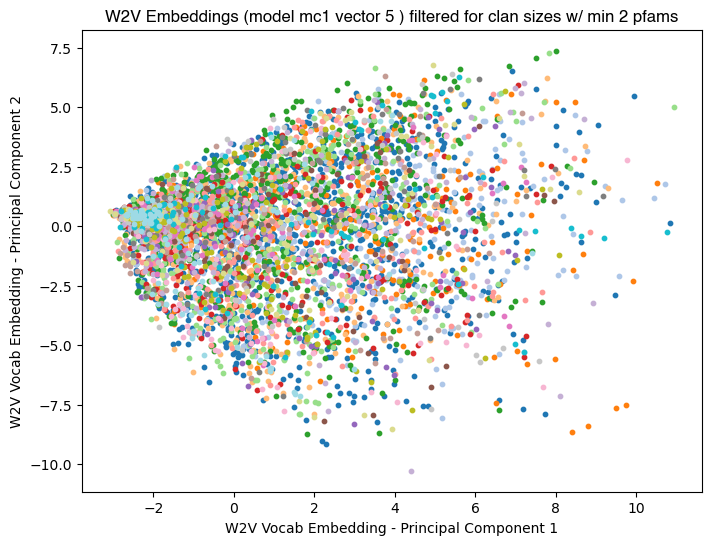

In [141]:
model_dir       = "/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/data/models/test/"

'''
model_files    = find_files(model_dir, 'model')

print(f"min clan size \t| model_name  \t\t\t| min_count | vector_size | vocab_count | filtered_pfams | filtered_clans")
for model_file in model_files:
    model_path  = model_file[0]
    model_name  = model_file[1]
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count   = min_count_s.group(1)
    vector_s    = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)
    
    # get vocab details
    full_vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=True)
    #print(f"{model_name} : {model_name}  | {min_count} | {vector_size} | {vocab_count}")
    
    #min_clan_sizes = [2 ,3, 5, 8, 10]
    min_clan_sizes = [2]
    
    
    for min_cs in min_clan_sizes:
        filtered_pfams, filtered_clans, filtered_clan_dict = get_pfam_clans_for_model(model_name, model_path, min_cs)
        print(f"min clan : {min_cs} \t| {model_name}  \t| {min_count} | {vector_size} | {vocab_count} | {len(filtered_pfams)} | {len(filtered_clans)}")
'''
#model_names = ['w2v_20240911_sg1_mc1_w3_v5', 'w2v_20240911_cbow_mc8_w44_v50']
model_names = ['w2v_20240911_sg1_mc1_w3_v5']

min_cs = 2
for model_name in model_names:
    model_path  = model_dir+model_name+'.model'
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count   = min_count_s.group(1)
    vector_s    = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)

    # get vocab for model
    full_vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=True)
    filtered_pfams, filtered_clans, filtered_clan_dict = get_pfam_clans_for_model(model_name, model_path, min_cs)
    
    X, Y = get_clustering_inputs(model_path, filtered_pfams, 5)
    
    print(f"model {model_name} {min_count} vs:{vector_size} full vocab size : {vocab_count} {len(full_vocab)} | X: {X.shape} | Y : {len(Y)} | clans : {len(filtered_clans)}")
    
    title = 'W2V Embeddings (model ' + str(min_count) +' vector ' + str(vector_size) +' ) filtered for clan sizes w/ min '+ str(min_cs)+' pfams'
    #graph_2d_pca(X, title)
    graph_2d_pca_color(X, Y, title)

## GRAPHS

In [26]:
def graph_2d(X, model_name):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.datasets import make_blobs

    # Generate a random multi-dimensional dataset (e.g., 5 dimensions)
    #X, _ = make_blobs(n_samples=100, n_features=5, centers=3, random_state=42)

    # Apply PCA to reduce it to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    comic_font = {'fontname':'Comic Sans MS'}
    helv_font = {'fontname':'Helvetica'}

    # Plot the 2D projection
    plt.figure(figsize=(4, 3))
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c='#069AF3', marker='o', edgecolor='#069AF3', s=10)
    plt.title(f"W2V Model : {model_name} - Principal Components", **helv_font)
    
    # change size of font used for tick marks on axes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # label the axes - using a font
    plt.xlabel("Vocab : PC 1", **helv_font)
    plt.ylabel("Vocab : PC 2", **helv_font)
    
    plt.grid(False)
    plt.show()
    
def graph_3d(X):
    
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from mpl_toolkits.mplot3d import Axes3D

    # Step 1: Create a sample multi-dimensional dataset (e.g., 5D)
    #np.random.seed(42)
    #data = np.random.rand(100, 5)  # 100 points in 5D space

    # Step 2: Apply PCA to reduce to 3D
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(X)

    # Step 3: Plot the reduced data in 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the 3D projection
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c='blue', marker='o')

    # Label axes
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Show plot
    plt.show()

In [37]:
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union
 
set_a = {"Geeks", "for", "Geeks", "NLP", "DSc"}
set_b = {"Geek", "for", "Geeks", "DSc.", 'ML', "DSA"}
 
similarity = jaccard_similarity(set_a, set_b)
print("Jaccard Similarity:", similarity)

Jaccard Similarity: 0.25


## DEFINE MODELS & GET VOCAB VECTORS

### Graph the vectors in a model vocab

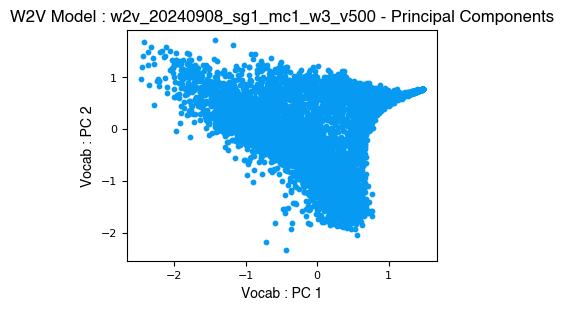

In [34]:
#model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/all_models_final/skip_mc8/"
#model_names=['w2v_20240901_sg1_mc8_w8_v5', 'w2v_20240901_sg1_mc8_w8_v10', 'w2v_20240901_sg1_mc8_w8_v25', 'w2v_20240901_sg1_mc8_w8_v50', 'w2v_20240901_sg1_mc8_w8_v75', 'w2v_20240901_sg1_mc8_w8_v100']

#model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/"
#model_names = ['w2v_20240908_sg1_mc1_w3_v250']

model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/"
#model_names = ['w2v_20240908_sg1_mc1_w3_v250']
model_names = ['w2v_20240908_sg1_mc1_w3_v500']

for model_name in model_names:

    model_path = model_dir+model_name+'.model'
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count = min_count_s.group(1)
    vector_s = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)

    # get vocab for model
    #vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=False)
    vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=True)
    
    X, Y, pfam_ids = get_model_vectors_clan_only(model_path, min_count, int(vector_size))
    
    graph_2d(X, model_name)

#### Min Count 8 - Window Size 13

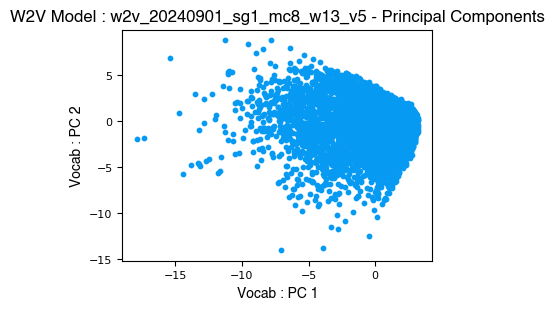

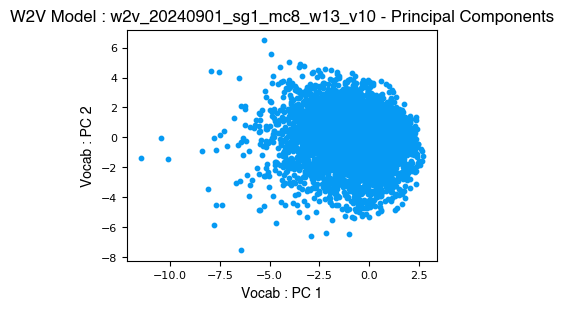

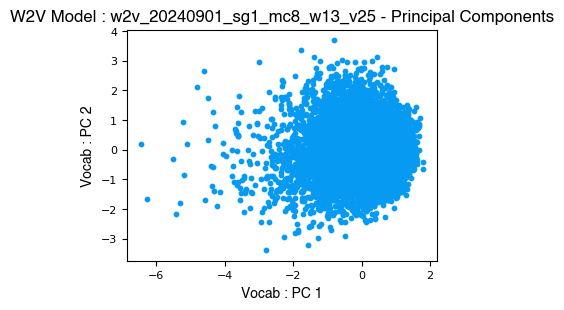

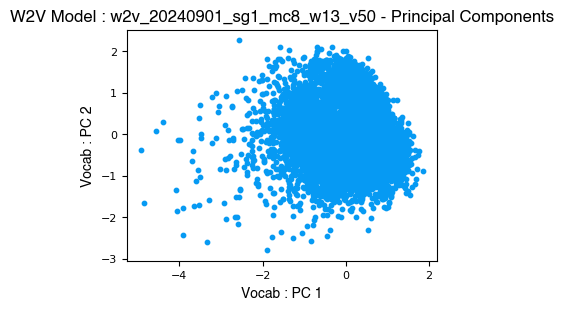

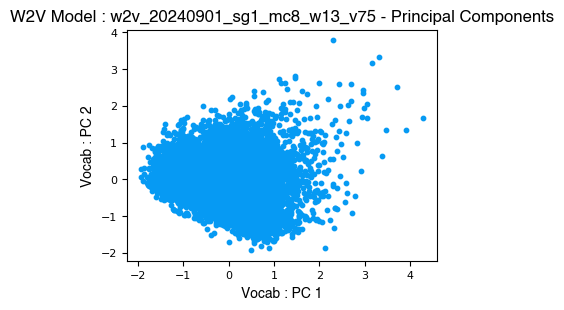

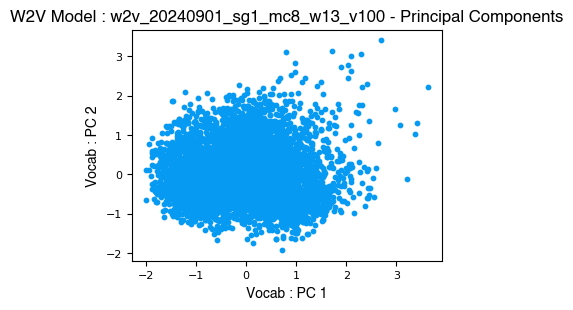

In [36]:
model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/all_models_final/skip_mc8/"
model_names=['w2v_20240901_sg1_mc8_w13_v5', 'w2v_20240901_sg1_mc8_w13_v10', 'w2v_20240901_sg1_mc8_w13_v25', 'w2v_20240901_sg1_mc8_w13_v50', 'w2v_20240901_sg1_mc8_w13_v75', 'w2v_20240901_sg1_mc8_w13_v100']


for model_name in model_names:

    model_path = model_dir+model_name+'.model'
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count = min_count_s.group(1)
    vector_s = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)

    vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=False)
    
    X, Y, pfam_ids = get_model_vectors_clan_only(model_path, min_count, int(vector_size))
    
    graph_2d(X, model_name)

#### Min Count 8 - Window Size 44

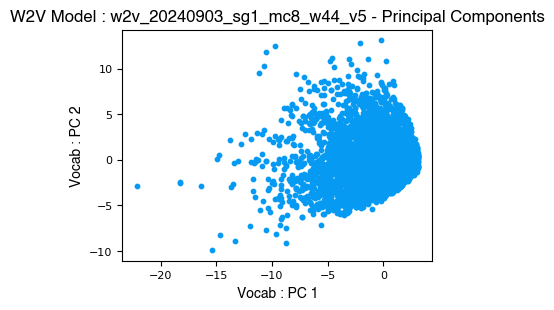

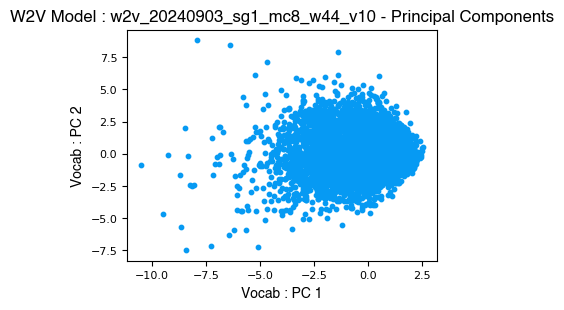

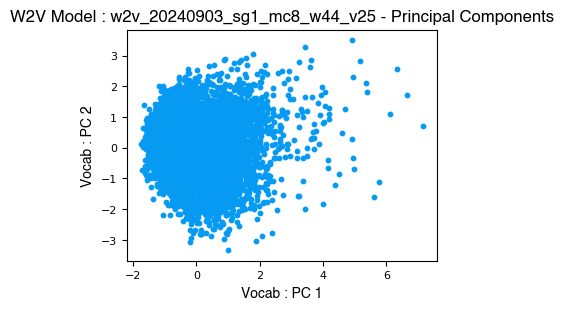

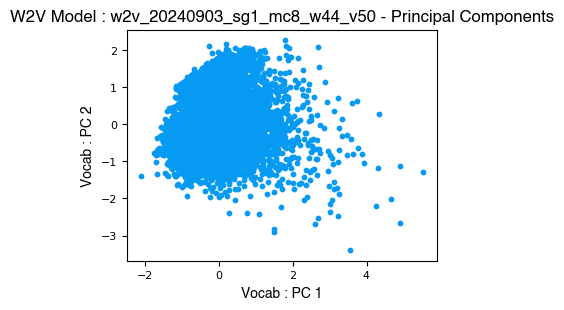

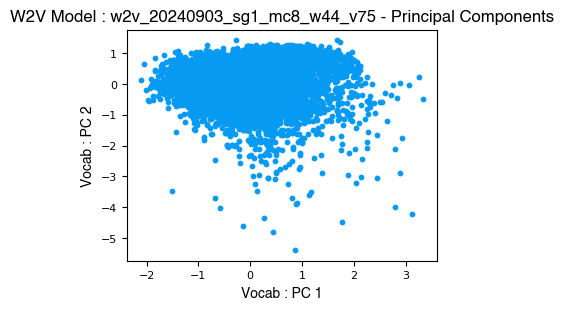

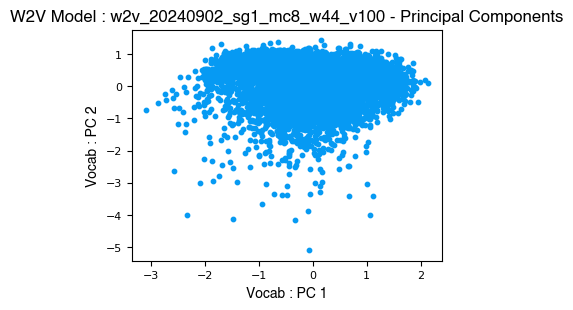

In [35]:
model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/all_models_final/skip_mc8/"
model_names=['w2v_20240903_sg1_mc8_w44_v5', 'w2v_20240903_sg1_mc8_w44_v10', 'w2v_20240903_sg1_mc8_w44_v25', 'w2v_20240903_sg1_mc8_w44_v50', 'w2v_20240903_sg1_mc8_w44_v75', 'w2v_20240902_sg1_mc8_w44_v100']


for model_name in model_names:

    model_path = model_dir+model_name+'.model'
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count = min_count_s.group(1)
    vector_s = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)

    vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=False)
    
    X, Y, pfam_ids = get_model_vectors_clan_only(model_path, min_count, int(vector_size))
    
    graph_2d(X, model_name)

#### Graph the models

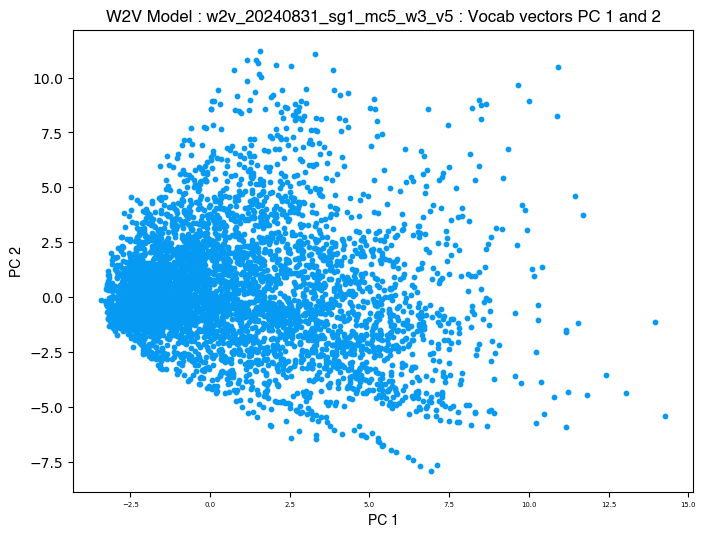

In [19]:
graph_2d(X, model_name)